<a href="https://colab.research.google.com/github/sandeeppalakkal/ML_Datascience_Practice/blob/master/Dog_Cat_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare Data

In [0]:
import tensorflow as tf
tf.enable_eager_execution()
import json
import os
import pdb
import glob
from sklearn.model_selection import train_test_split
import itertools
import numpy as np

In [2]:
# Get data from google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def json_write(data,json_file):
  json.dump(data,open(json_file,'w'))
  
def json_load(json_file):
  return json.load(open(json_file,'r'))

In [0]:
# Annotate & save json
def get_annotated_data(data_path):
  def _annotate(file_path):
    img_path = os.path.split(file_path)[1]
    return int(img_path[:3] != 'cat')
  train_data_imgs = sorted(glob.glob(data_path+'/*.jpg'))  
  train_data_annot = list(map(_annotate,train_data_imgs))
  data_dict = dict(zip(train_data_imgs,train_data_annot))
  return data_dict

In [0]:
# Train-val split
def train_val_split_data_dict(data_dict,train_size,random_state):
  train_x,test_x,train_y,test_y = train_test_split(list(data_dict.keys()),
                          list(data_dict.values()),
                          train_size = train_size,
                          random_state = random_state)
  train_dict = dict(zip(train_x,train_y))
  test_dict = dict(zip(test_x,test_y))
  return train_dict,test_dict

In [0]:
# data details
data_path = '/content/gdrive/My Drive/Datasets/DogCat/train'
train_json = '/content/gdrive/My Drive/Datasets/DogCat/train.json'
val_json = '/content/gdrive/My Drive/Datasets/DogCat/validation.json'
test_json = '/content/gdrive/My Drive/Datasets/DogCat/test.json'

In [7]:
# create & save annotations
FORCE = False
if FORCE or not all(map(os.path.os.path.exists,[train_json,val_json,test_json])):
  data_dict = get_annotated_data(data_path)
  train_dict,test_dict = train_val_split_data_dict(data_dict,0.6,33)
  val_dict,test_dict = train_val_split_data_dict(test_dict,0.5,30)
  json_write(train_dict,train_json)
  json_write(val_dict,val_json)
  json_write(test_dict,test_json)
  print("Created data annotations: \n%s \n%s \n%s" % (train_json,val_json,test_json))
else:
  print("Data annotations already exists!")

Data annotations already exists!


## Image Preprocessing Functions

In [0]:
# Image preprocessing
def preprocess_image(image,size=(224,224)):
  image = tf.image.decode_jpeg(image,channels=3)
  image = tf.image.resize_images(image,list(size))
  image /= 255.0
  return image

In [0]:
# load & preprocess
def load_and_preprocess_image(path):
  image = tf.read_file(path)
  image = preprocess_image(image)
  return image

## TF Dataset

In [0]:
# create tf dataset
def create_tf_image_dataset(img_paths,img_labels):  
  # load & preprocess image & label
  def _load_and_preprocess_from_path_label(path,label):
    return load_and_preprocess_image(path), label
  
  ds = tf.data.Dataset.from_tensor_slices((img_paths,img_labels))
  ds = ds.map(_load_and_preprocess_from_path_label)
  return ds

## Model Training

### TF Data Input Pipeline

In [0]:
train_dict_,val_dict_,test_dict_ = map(json_load,[train_json,val_json,test_json])

In [0]:
def reduce_data_size(data_dict,n):
  return dict(itertools.islice(data_dict.items(),n))

In [0]:
# Reduce data size
#train_dict = reduce_data_size(train_dict_,1000)
#val_dict = reduce_data_size(val_dict_,500)
#test_dict = reduce_data_size(test_dict_,500)
train_dict = train_dict_
val_dict = val_dict_
test_dict = test_dict_

In [14]:
print(len(train_dict),len(val_dict),len(test_dict))

15000 5000 5000


In [0]:
def create_tf_image_dataset_from_dict(data_dict):
  return create_tf_image_dataset(list(data_dict.keys()),list(data_dict.values()))
#train_ds,val_ds,test_ds = map(create_tf_image_dataset_from_dict,[train_dict,val_dict,test_dict])

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def data_pipeline(data_dict,shuffle_size,batch_size):
  ds = create_tf_image_dataset_from_dict(data_dict)
  ds = ds.shuffle(buffer_size=shuffle_size).batch(batch_size).repeat()
  #ds = ds.apply(
  #  tf.data.experimental.shuffle_and_repeat(buffer_size=shuffle_size))
  #ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [0]:
BATCH_SIZE = 32
train_ds_ = data_pipeline(train_dict,min(1000,len(train_dict)),BATCH_SIZE)
val_ds_ = data_pipeline(val_dict,min(1000,len(val_dict)),BATCH_SIZE)
test_ds_ = data_pipeline(test_dict,min(1000,len(test_dict)),BATCH_SIZE)

## Training in Keras

In [0]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),include_top=False)
mobile_net.trainable = False

In [0]:
#resnet50 = tf.keras.applications.ResNet50(input_shape=(224,224,3),include_top=False)
#resnet50.trainable = False

In [0]:
def change_range(image,label):
  return 2*image-1, label

keras_train_ds = train_ds_.map(change_range)
keras_val_ds = val_ds_.map(change_range)
keras_test_ds = test_ds_.map(change_range)

In [0]:
image_batch, label_batch = next(iter(keras_train_ds))

In [22]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 7, 7, 1280)


In [0]:
label_names = ['cat','dog']
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names),
                        activation = 'softmax',
                       kernel_regularizer=tf.keras.regularizers.l2(0.0001))])

In [0]:
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.0001), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [25]:
len(model.trainable_variables) 

2

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [27]:
history = model.fit(keras_train_ds, validation_data=keras_test_ds,validation_steps=3,
          validation_freq=1, epochs=10, steps_per_epoch=len(train_dict)//BATCH_SIZE)

Epoch 1/10


W0701 02:54:27.878903 139841933870976 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


468/468 [==============================] - 3613s 8s/step - loss: 0.3599 - acc: 0.8424 - val_loss: 0.2413 - val_acc: 0.8854
Epoch 2/10
468/468 [==============================] - 84s 179ms/step - loss: 0.1792 - acc: 0.9339 - val_loss: 0.1832 - val_acc: 0.9375
Epoch 3/10
468/468 [==============================] - 82s 176ms/step - loss: 0.1495 - acc: 0.9443 - val_loss: 0.1719 - val_acc: 0.9479
Epoch 4/10
468/468 [==============================] - 82s 175ms/step - loss: 0.1325 - acc: 0.9502 - val_loss: 0.1755 - val_acc: 0.9479
Epoch 5/10
468/468 [==============================] - 82s 176ms/step - loss: 0.1209 - acc: 0.9552 - val_loss: 0.1660 - val_acc: 0.9583
Epoch 6/10
468/468 [==============================] - 81s 174ms/step - loss: 0.1171 - acc: 0.9549 - val_loss: 0.1741 - val_acc: 0.9583
Epoch 7/10
468/468 [==============================] - 81s 173ms/step - loss: 0.1071 - acc: 0.9586 - val_loss: 0.1644 - val_acc: 0.9583
Epoch 8/10
468/468 [==============================] - 81s 173ms/ste

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


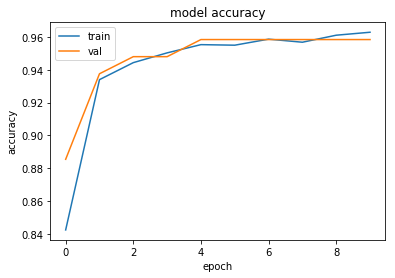

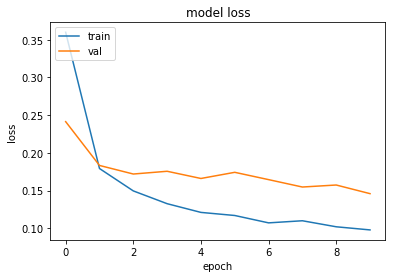

In [28]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
# serialize model to JSON
model_path = '/content/gdrive/My Drive/Datasets/DogCat/'
model_json = model.to_json()
with open(os.path.join(model_path,"model.json"), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(os.path.join(model_path,"model.h5"))
print("Saved model to disk")

Saved model to disk


In [30]:
scores = model.evaluate(keras_train_ds,steps = len(train_dict)//BATCH_SIZE)
scores = model.evaluate(keras_val_ds,steps = len(val_dict)//BATCH_SIZE)
scores = model.evaluate(keras_test_ds,steps = len(test_dict)//BATCH_SIZE)

156/156 [==============================] - 913s 6s/step - loss: 0.0888 - acc: 0.9696


In [0]:
predictions = model.predict(keras_test_ds,steps = len(test_dict)//BATCH_SIZE)

In [0]:
train_img_path = '/content/gdrive/My Drive/Datasets/DogCat/train'
train_imgs = sorted(glob.glob(train_img_path+'/*.jpg'))

Predicted: Cat


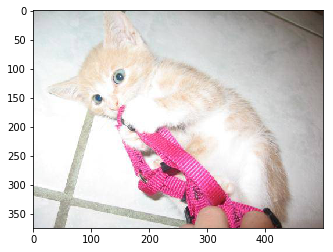

Predicted: Dog


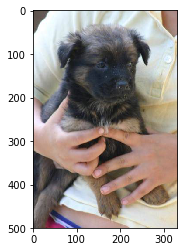

Predicted: Dog


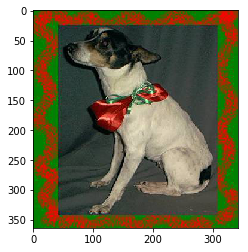

Predicted: Cat


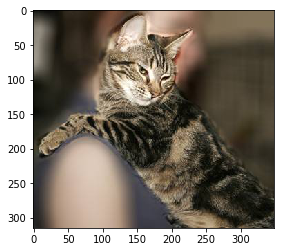

Predicted: Cat


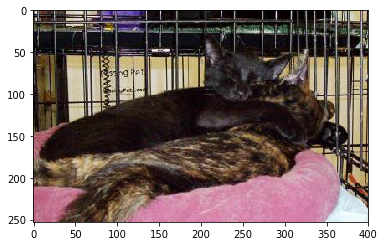

Predicted: Dog


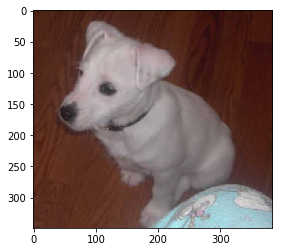

Predicted: Cat


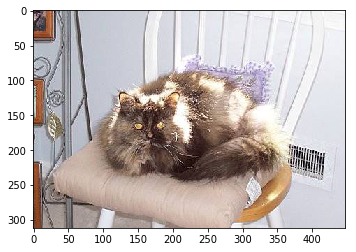

Predicted: Cat


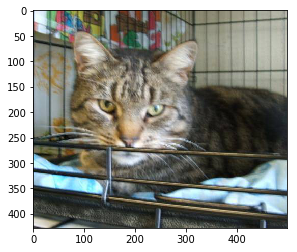

Predicted: Cat


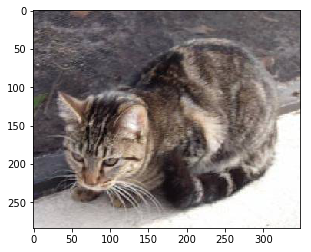

Predicted: Cat


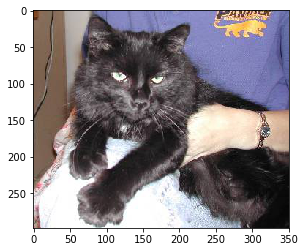

Predicted: Dog


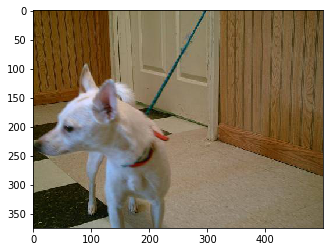

Predicted: Dog


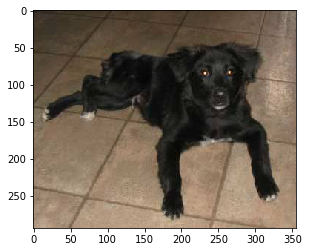

Predicted: Dog


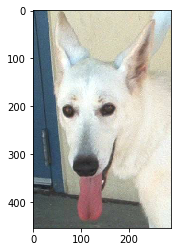

Predicted: Cat


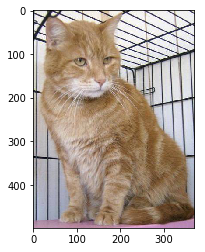

Predicted: Cat


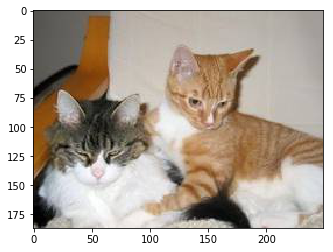

Predicted: Dog


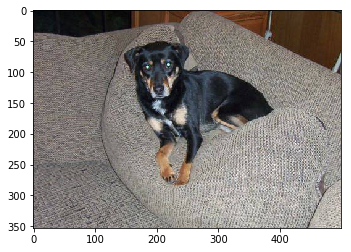

Predicted: Cat


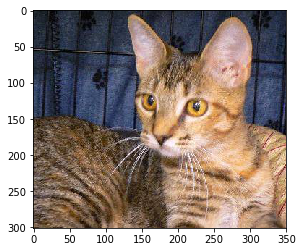

Predicted: Dog


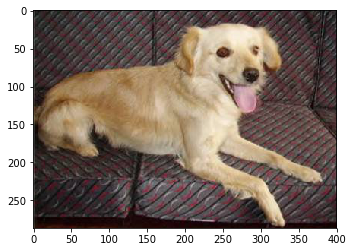

Predicted: Dog


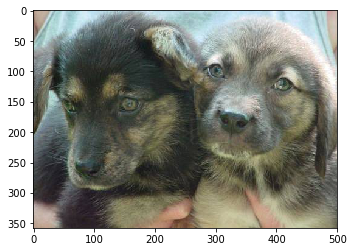

Predicted: Cat


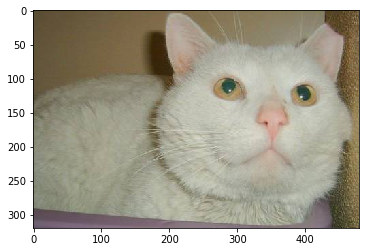

In [33]:
classes = ['Cat','Dog']
ind = np.random.randint(len(train_imgs),size=20)
imgs = [train_imgs[j] for j in ind]
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
for img in imgs:
  x = load_and_preprocess_image(img)
  x,_ = change_range(x,_)
  x = tf.expand_dims(x,0)
  y = model.predict(x,steps=1)
  c = np.argmax(y)
  print("Predicted: %s" % classes[c])
  plt.imshow(Image.open(img,'r'))
  plt.show()

## Predict on Test Data

In [0]:
test_img_path = '/content/gdrive/My Drive/Datasets/DogCat/test1'
test_imgs = sorted(glob.glob(test_img_path+'/*.jpg'))

Predicted: Cat


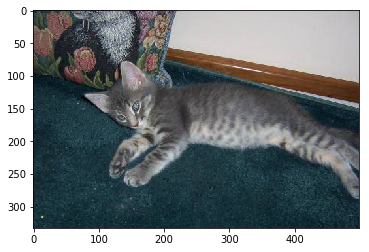

Predicted: Cat


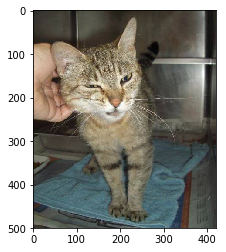

Predicted: Dog


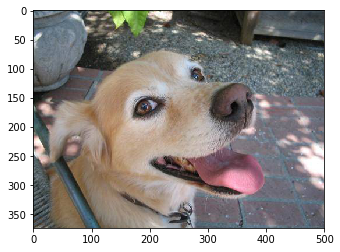

Predicted: Cat


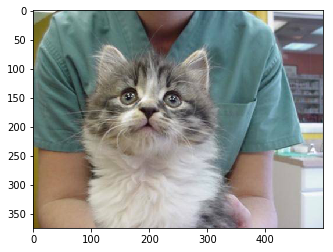

Predicted: Cat


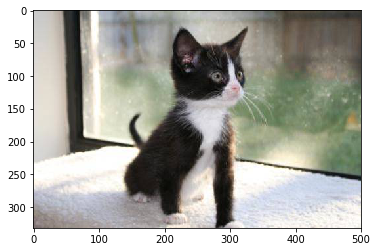

In [36]:
classes = ['Cat','Dog']
ind = np.random.randint(len(test_imgs),size=5,)
imgs = [test_imgs[j] for j in ind]
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
for img in imgs:
  x = load_and_preprocess_image(img)
  x,_ = change_range(x,_)
  x = tf.expand_dims(x,0)
  y = model.predict(x,steps=1)
  c = np.argmax(y)
  print("Predicted: %s" % classes[c])
  plt.imshow(Image.open(img,'r'))
  plt.show()

In [0]:
#ind = np.random.randint(len(test_imgs),size=5)
#type(ind)

In [0]:
#ind

In [0]:
#import matplotlib.pyplot as plt

#def return_img(img,label):
#  return img

#imgs__ = train_ds_.take(4)
#imgs__ = imgs__.map(return_img)
#plt.figure(figsize=(8,8))
#for n,image in enumerate(imgs__):
#  plt.subplot(2,2,n+1)
#  #pdb.set_trace()
#  #plt.imshow(tf.squeeze(image))
#  plt.imshow(image)
#  plt.grid(False)
#  plt.xticks([])
#  plt.yticks([])
#  plt.xlabel(caption_image(all_image_paths[n]))

In [0]:
#imgs__